# Import all libraries!

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE

## Path ke folder dataset 

In [2]:
# Path ke folder dataset
dataset_path = "dataset"

# Fungsi untuk membaca semua file CSV dalam folder dataset dengan encoding yang aman
def load_datasets(path=dataset_path, encoding_list=['utf-8', 'ISO-8859-1', 'latin1']):
    """Membaca semua file CSV dalam folder dataset dengan berbagai encoding."""
    datasets = {}
    for file in os.listdir(path):
        if file.endswith(".csv"):
            file_path = os.path.join(path, file)
            for encoding in encoding_list:
                try:
                    df = pd.read_csv(file_path, encoding=encoding)
                    datasets[file] = df
                    print(f"{file}: {df.shape} loaded successfully with encoding {encoding}")
                    break
                except UnicodeDecodeError:
                    print(f"Error decoding {file} with encoding {encoding}, trying next...")
    return datasets

# Load datasets
datasets = load_datasets()

application_test.csv: (48744, 121) loaded successfully with encoding utf-8
application_train.csv: (307511, 122) loaded successfully with encoding utf-8
bureau.csv: (1716428, 17) loaded successfully with encoding utf-8
bureau_balance.csv: (27299925, 3) loaded successfully with encoding utf-8
credit_card_balance.csv: (3840312, 23) loaded successfully with encoding utf-8
Error decoding HomeCredit_columns_description.csv with encoding utf-8, trying next...
HomeCredit_columns_description.csv: (219, 5) loaded successfully with encoding ISO-8859-1
installments_payments.csv: (13605401, 8) loaded successfully with encoding utf-8
POS_CASH_balance.csv: (10001358, 8) loaded successfully with encoding utf-8
previous_application.csv: (1670214, 37) loaded successfully with encoding utf-8
sample_submission.csv: (48744, 2) loaded successfully with encoding utf-8


## Eksplorasi Data Awal



In [3]:
for name, df in datasets.items():
    print(f"Dataset: {name}")
    print(df.info())
    print(df.isnull().sum())
    print("\n" + "="*50 + "\n")  


Dataset: application_test.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None
SK_ID_CURR                       0
NAME_CONTRACT_TYPE               0
CODE_GENDER                      0
FLAG_OWN_CAR                     0
FLAG_OWN_REALTY                  0
                              ... 
AMT_REQ_CREDIT_BUREAU_DAY     6049
AMT_REQ_CREDIT_BUREAU_WEEK    6049
AMT_REQ_CREDIT_BUREAU_MON     6049
AMT_REQ_CREDIT_BUREAU_QRT     6049
AMT_REQ_CREDIT_BUREAU_YEAR    6049
Length: 121, dtype: int64


Dataset: application_train.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None
SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE             

### Analisis Eksplorasi Data Awal

Dataset utama, yaitu **application_train.csv**, terdiri dari 307.511 entri dengan 122 kolom, di mana terdapat banyak missing values, terutama pada kolom terkait permintaan kredit seperti `AMT_REQ_CREDIT_BUREAU_YEAR`, yang memiliki 41.519 nilai kosong. Dataset **application_test.csv**, yang digunakan untuk pengujian model, memiliki 48.744 entri dengan 121 kolom, dan juga mengandung beberapa nilai yang hilang.

Selain dataset utama, terdapat beberapa dataset tambahan yang berisi informasi kredit pelanggan. **bureau.csv** menyimpan data pinjaman sebelumnya dari lembaga keuangan lain dengan 1.716.428 entri dan 17 kolom, di mana beberapa kolom seperti `DAYS_CREDIT_ENDDATE`, `AMT_CREDIT_MAX_OVERDUE`, dan `AMT_ANNUITY` memiliki banyak missing values. Dataset **bureau_balance.csv** berisi status bulanan dari kredit dalam **bureau.csv**, memiliki 27.299.925 entri dengan 3 kolom, dan tidak memiliki nilai yang hilang. 

Dataset **credit_card_balance.csv**, yang mencatat saldo kartu kredit pelanggan, berisi 3.840.312 entri dengan 23 kolom, di mana beberapa kolom seperti `AMT_DRAWINGS_ATM_CURRENT` memiliki jumlah missing values yang signifikan. Dataset **installments_payments.csv** mencatat histori pembayaran cicilan pelanggan dengan 13.605.401 entri dan 8 kolom, di mana terdapat beberapa missing values pada kolom `DAYS_ENTRY_PAYMENT` dan `AMT_PAYMENT`. Sementara itu, **POS_CASH_balance.csv**, yang berisi snapshot bulanan dari POS dan pinjaman tunai, memiliki 10.001.358 entri, dengan beberapa kolom seperti `CNT_INSTALMENT` dan `CNT_INSTALMENT_FUTURE` yang mengandung missing values.

Dataset **previous_application.csv** menyimpan data aplikasi kredit sebelumnya dari pelanggan dengan 1.670.214 entri dan 37 kolom, di mana beberapa kolom seperti `RATE_INTEREST_PRIMARY` memiliki jumlah missing values yang sangat besar. Temuan penting dari eksplorasi ini menunjukkan bahwa banyak kolom memiliki missing values yang signifikan, terutama pada informasi kredit sebelumnya dan transaksi pelanggan. Selain itu, dataset utama memiliki fitur kategorikal dan numerik, yang memerlukan encoding dan scaling sebelum digunakan dalam pemodelan. Jumlah data pada beberapa tabel sangat besar, terutama **bureau_balance.csv** dan **installments_payments.csv**, yang dapat mempengaruhi performa pemrosesan data. Beberapa dataset ini juga mencerminkan histori kredit dan transaksi pelanggan, yang dapat menjadi fitur penting dalam model machine learning yang akan dikembangkan.



## Analisis Faktor yang Mempengaruhi Keputusan Kredit
Agar model lebih akurat, kita akan melihat bagaimana faktor-faktor tertentu mempengaruhi kemungkinan pelanggan untuk membayar kembali pinjaman.


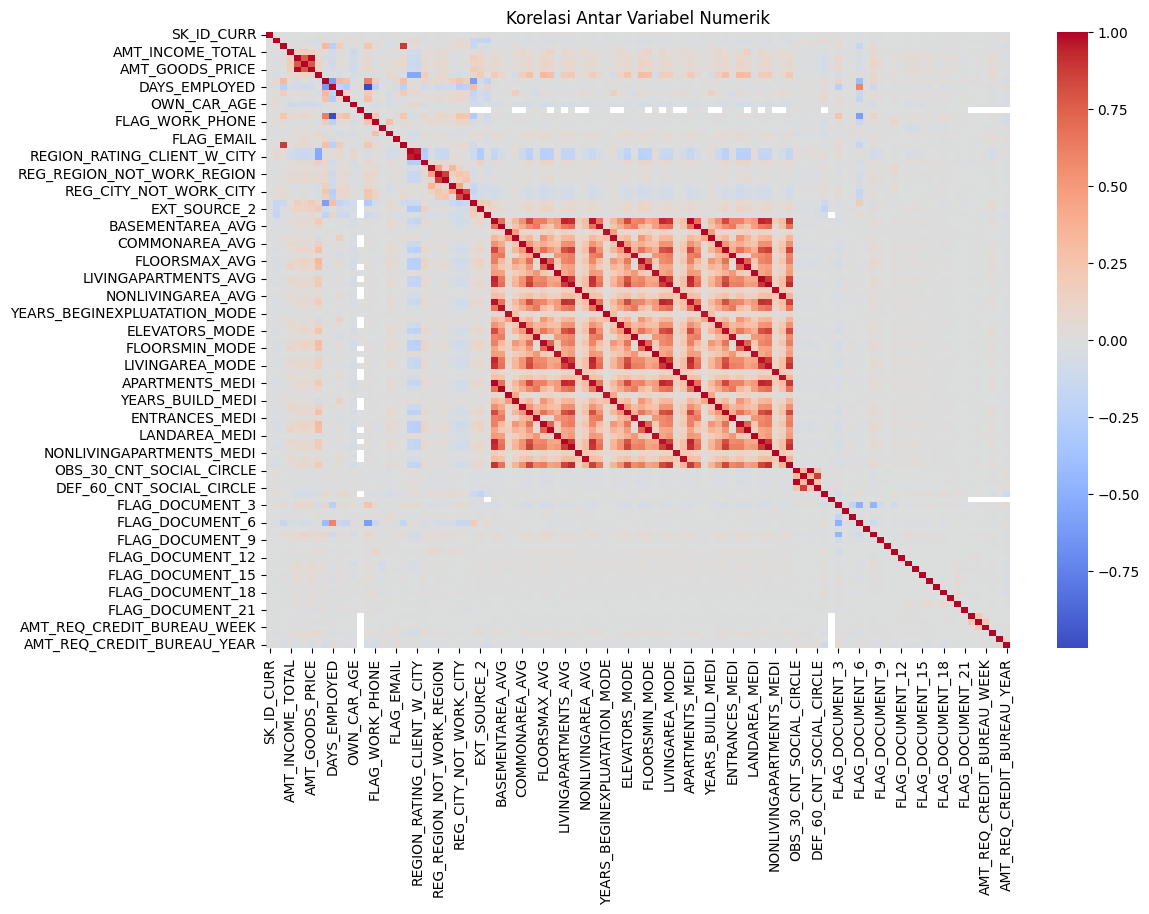

In [4]:
# Pilih dataset utama
df_train = datasets["application_train.csv"]

# Pilih hanya kolom numerik
numeric_cols = df_train.select_dtypes(include=['number'])

# Korelasi antara variabel numerik dan target
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_cols.corr(), annot=False, cmap='coolwarm')
plt.title("Korelasi Antar Variabel Numerik")
plt.show()


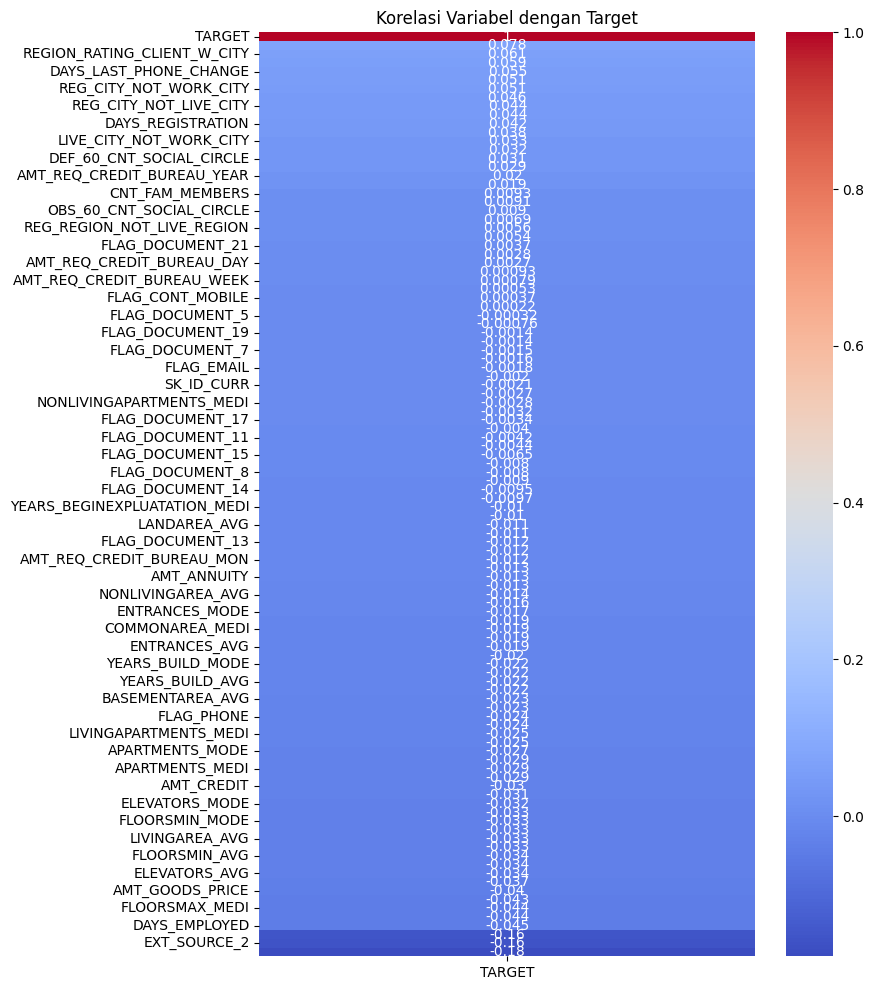

In [5]:
# Korelasi variabel dengan TARGET
plt.figure(figsize=(8, 12))
correlation = numeric_cols.corr()["TARGET"].sort_values(ascending=False)
sns.heatmap(correlation.to_frame(), annot=True, cmap='coolwarm')
plt.title("Korelasi Variabel dengan Target")
plt.show()


Dua heatmap yang dihasilkan membantu dalam memahami hubungan antara variabel-variabel numerik dalam dataset serta korelasinya terhadap target (*default* atau tidak).

#### 1. Korelasi Antar Variabel Numerik
Visualisasi pertama menampilkan **korelasi antara variabel numerik dalam dataset**. Dari pola yang terlihat, beberapa kelompok variabel memiliki korelasi tinggi satu sama lain, yang tampak sebagai blok merah diagonal. Hal ini menunjukkan adanya **redundansi antar variabel**, yang dapat menyebabkan multikolinearitas dalam model prediksi. Beberapa variabel tampaknya memiliki korelasi rendah atau hampir nol satu sama lain, yang berarti mereka memiliki kontribusi independen dalam model.

#### 2. Korelasi Variabel dengan Target
Heatmap kedua menunjukkan **korelasi antara setiap variabel numerik dengan variabel target**. Mayoritas variabel memiliki korelasi yang rendah dengan target (*<0.1 atau >-0.1*), menunjukkan bahwa tidak ada variabel yang secara langsung memiliki pengaruh dominan terhadap keputusan kredit. Beberapa variabel seperti **EXT_SOURCE_2, DAYS_EMPLOYED, dan AMT_GOODS_PRICE** menunjukkan korelasi yang lebih besar dibandingkan variabel lain:

- **EXT_SOURCE_2** memiliki korelasi negatif yang cukup signifikan, yang menunjukkan bahwa skor eksternal mungkin memainkan peran penting dalam menentukan risiko kredit.
- **DAYS_EMPLOYED** juga menunjukkan korelasi negatif, yang berarti semakin lama seseorang bekerja, semakin kecil kemungkinan mereka mengalami gagal bayar.
- **AMT_GOODS_PRICE** memiliki sedikit korelasi dengan keputusan kredit, yang mungkin menunjukkan bahwa jumlah pinjaman yang diajukan bukan satu-satunya faktor dalam menentukan risiko.




## Data cleaning & Feature Engineering

In [6]:
# Data Cleaning - Handling Missing Values
for name, df in datasets.items():
    print(f"\nCleaning dataset: {name}")
    # Hapus kolom dengan lebih dari 50% missing values
    threshold = 0.5 * df.shape[0]
    df.dropna(thresh=threshold, axis=1, inplace=True)
    
    # Isi missing values untuk kolom numerik dengan median
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if len(num_cols) > 0:
        imputer = SimpleImputer(strategy='median')
        df[num_cols] = imputer.fit_transform(df[num_cols])
    
    # Isi missing values untuk kolom kategori dengan modus
    cat_cols = df.select_dtypes(include=['object']).columns
    if len(cat_cols) > 0:
        imputer_cat = SimpleImputer(strategy='most_frequent')
        df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])
    
    datasets[name] = df
    print(f"Missing values handled in {name}.")


Cleaning dataset: application_test.csv
Missing values handled in application_test.csv.

Cleaning dataset: application_train.csv
Missing values handled in application_train.csv.

Cleaning dataset: bureau.csv
Missing values handled in bureau.csv.

Cleaning dataset: bureau_balance.csv
Missing values handled in bureau_balance.csv.

Cleaning dataset: credit_card_balance.csv
Missing values handled in credit_card_balance.csv.

Cleaning dataset: HomeCredit_columns_description.csv
Missing values handled in HomeCredit_columns_description.csv.

Cleaning dataset: installments_payments.csv
Missing values handled in installments_payments.csv.

Cleaning dataset: POS_CASH_balance.csv
Missing values handled in POS_CASH_balance.csv.

Cleaning dataset: previous_application.csv
Missing values handled in previous_application.csv.

Cleaning dataset: sample_submission.csv
Missing values handled in sample_submission.csv.


In [7]:
# Feature Engineering - Encoding Categorical Data
for name, df in datasets.items():
    print(f"\nEncoding categorical features in {name}")
    cat_cols = df.select_dtypes(include=['object']).columns
    label_enc = LabelEncoder()
    for col in cat_cols:
        df[col] = label_enc.fit_transform(df[col])
    datasets[name] = df
    print(f"Categorical features encoded in {name}.")


Encoding categorical features in application_test.csv
Categorical features encoded in application_test.csv.

Encoding categorical features in application_train.csv
Categorical features encoded in application_train.csv.

Encoding categorical features in bureau.csv
Categorical features encoded in bureau.csv.

Encoding categorical features in bureau_balance.csv
Categorical features encoded in bureau_balance.csv.

Encoding categorical features in credit_card_balance.csv
Categorical features encoded in credit_card_balance.csv.

Encoding categorical features in HomeCredit_columns_description.csv
Categorical features encoded in HomeCredit_columns_description.csv.

Encoding categorical features in installments_payments.csv
Categorical features encoded in installments_payments.csv.

Encoding categorical features in POS_CASH_balance.csv
Categorical features encoded in POS_CASH_balance.csv.

Encoding categorical features in previous_application.csv
Categorical features encoded in previous_applic

In [8]:
# Normalization/Scaling untuk application_train.csv
if 'application_train.csv' in datasets:
    print("\nScaling numerical features in application_train.csv")
    scaler = StandardScaler()
    num_cols = datasets['application_train.csv'].select_dtypes(include=['float64', 'int64']).columns.drop('TARGET', errors='ignore')
    datasets['application_train.csv'][num_cols] = scaler.fit_transform(datasets['application_train.csv'][num_cols])
    print("Feature scaling applied to application_train.csv")


Scaling numerical features in application_train.csv
Feature scaling applied to application_train.csv


In [9]:
# Save Cleaned Data
for name, df in datasets.items():
    df.to_csv(f"cleaned_{name}", index=False)
    print(f"Cleaned dataset saved as cleaned_{name}")

Cleaned dataset saved as cleaned_application_test.csv
Cleaned dataset saved as cleaned_application_train.csv
Cleaned dataset saved as cleaned_bureau.csv
Cleaned dataset saved as cleaned_bureau_balance.csv
Cleaned dataset saved as cleaned_credit_card_balance.csv
Cleaned dataset saved as cleaned_HomeCredit_columns_description.csv
Cleaned dataset saved as cleaned_installments_payments.csv
Cleaned dataset saved as cleaned_POS_CASH_balance.csv
Cleaned dataset saved as cleaned_previous_application.csv
Cleaned dataset saved as cleaned_sample_submission.csv


## Penggalian Insight


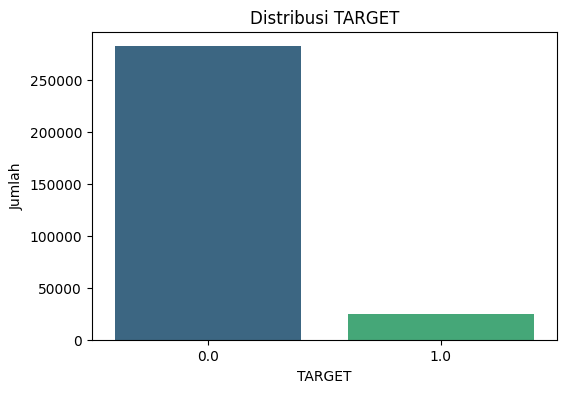


Fitur dengan korelasi tertinggi dengan TARGET:
TARGET                         1.000000
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
NAME_EDUCATION_TYPE            0.054699
CODE_GENDER                    0.054692
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
NAME_INCOME_TYPE               0.046829
Name: TARGET, dtype: float64


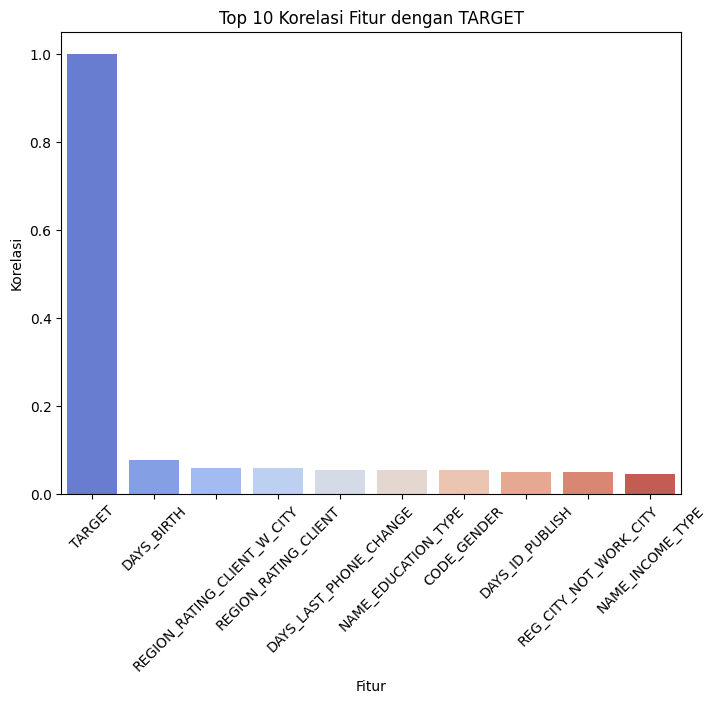

In [10]:
# Penggalian Insight - Analisis hubungan fitur dengan TARGET
if 'application_train.csv' in datasets:
    df = datasets['application_train.csv']
    
    # Visualisasi distribusi TARGET
    plt.figure(figsize=(6, 4))
    sns.countplot(x=df['TARGET'], hue=df['TARGET'], palette='viridis', legend=False)
    plt.title("Distribusi TARGET")
    plt.xlabel("TARGET")
    plt.ylabel("Jumlah")
    plt.show()
    
    # Korelasi fitur dengan TARGET
    corr_matrix = df.corr()
    target_corr = corr_matrix['TARGET'].sort_values(ascending=False)
    print("\nFitur dengan korelasi tertinggi dengan TARGET:")
    print(target_corr.head(10))
    
    # Visualisasi fitur dengan korelasi tertinggi
    plt.figure(figsize=(8, 6))
    sns.barplot(x=target_corr.head(10).index, y=target_corr.head(10).values, hue=target_corr.head(10).index, palette='coolwarm', legend=False)
    plt.xticks(rotation=45)
    plt.title("Top 10 Korelasi Fitur dengan TARGET")
    plt.xlabel("Fitur")
    plt.ylabel("Korelasi")
    plt.show()

### Hasil Analisis Penggalian Insight


#### 1. Distribusi TARGET
Hasil visualisasi distribusi **TARGET** menunjukkan adanya **ketidakseimbangan kelas** yang signifikan. Mayoritas data termasuk dalam kategori **0 (tidak gagal bayar)**, sedangkan hanya sebagian kecil yang termasuk dalam kategori **1 (gagal bayar)**. Hal ini menandakan bahwa data **sangat imbalanced**, yang dapat mempengaruhi performa model machine learning jika tidak ditangani dengan baik. 

#### 2. Korelasi Fitur dengan TARGET
Analisis korelasi menunjukkan bahwa **tidak ada fitur yang memiliki korelasi yang sangat tinggi dengan TARGET**. Beberapa fitur dengan korelasi tertinggi meliputi:
- **DAYS_BIRTH (0.078)** → Semakin tua seseorang, semakin kecil kemungkinan mereka mengalami gagal bayar.
- **REGION_RATING_CLIENT_W_CITY (0.0609)** → Faktor lokasi tempat tinggal tampaknya memiliki hubungan dengan risiko kredit.
- **REGION_RATING_CLIENT (0.0589)** → Mirip dengan rating wilayah tempat tinggal, hal ini dapat berpengaruh pada kebijakan risiko kredit.
- **DAYS_LAST_PHONE_CHANGE (0.0552)** → Klien yang lebih sering mengganti nomor telepon cenderung memiliki risiko lebih tinggi.
- **NAME_EDUCATION_TYPE (0.0547)** → Tingkat pendidikan tampaknya memiliki sedikit pengaruh terhadap kemungkinan gagal bayar.
- **CODE_GENDER (0.0546)** → Ada sedikit korelasi antara jenis kelamin dengan risiko kredit.
- **DAYS_ID_PUBLISH (0.0514)** → Semakin baru dokumen identitas diterbitkan, semakin tinggi kemungkinan gagal bayar.
- **REG_CITY_NOT_WORK_CITY (0.0509)** → Jika kota tempat tinggal berbeda dengan kota tempat bekerja, terdapat sedikit peningkatan risiko gagal bayar.
- **NAME_INCOME_TYPE (0.0468)** → Sumber pendapatan juga memiliki sedikit korelasi terhadap risiko kredit.



## Modeling

In [11]:
# Modeling - Logistic Regression, Random Forest & Gradient Boosting
if os.path.exists("cleaned_application_train.csv"):
    df = pd.read_csv("cleaned_application_train.csv")
    
    # Pisahkan fitur dan target
    X = df.drop(columns=['TARGET', 'SK_ID_CURR'], errors='ignore')
    y = df['TARGET']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Model Logistic Regression
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(X_train, y_train)
    y_pred_logreg = logreg.predict(X_test)
    print("\nLogistic Regression Evaluation:")
    print(classification_report(y_test, y_pred_logreg))
    print("ROC-AUC Score:", roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1]))
    
    # Model Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    print("\nRandom Forest Evaluation:")
    print(classification_report(y_test, y_pred_rf))
    print("ROC-AUC Score:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))
    
    # Model Gradient Boosting
    gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
    gb.fit(X_train, y_train)
    y_pred_gb = gb.predict(X_test)
    print("\nGradient Boosting Evaluation:")
    print(classification_report(y_test, y_pred_gb))
    print("ROC-AUC Score:", roc_auc_score(y_test, gb.predict_proba(X_test)[:,1]))


Logistic Regression Evaluation:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56554
         1.0       0.46      0.01      0.02      4949

    accuracy                           0.92     61503
   macro avg       0.69      0.50      0.49     61503
weighted avg       0.88      0.92      0.88     61503

ROC-AUC Score: 0.7394558849738636

Random Forest Evaluation:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56554
         1.0       0.57      0.00      0.00      4949

    accuracy                           0.92     61503
   macro avg       0.75      0.50      0.48     61503
weighted avg       0.89      0.92      0.88     61503

ROC-AUC Score: 0.7084343230540937

Gradient Boosting Evaluation:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56554
         1.0       0.58      0.01      0.02      4949

    accuracy           

### Analisis Hasil Modeling

#### 1. Model yang Digunakan
Pada tahap ini, tiga model Machine Learning diterapkan untuk memprediksi risiko gagal bayar:
- **Logistic Regression** → Model baseline yang sederhana dan sering digunakan dalam prediksi kredit.
- **Random Forest Classifier** → Model berbasis ensemble yang dapat menangani data kompleks.
- **Gradient Boosting Classifier** → Model boosting yang dapat meningkatkan akurasi prediksi dengan memanfaatkan kesalahan model sebelumnya.

### 2. Perbandingan Hasil Evaluasi Model
Berikut adalah hasil evaluasi dari ketiga model berdasarkan metrik utama:

| Model                | Akurasi | Precision (Class 1) | Recall (Class 1) | F1-Score (Class 1) | ROC-AUC Score |
|----------------------|---------|---------------------|------------------|--------------------|---------------|
| Logistic Regression | 92%     | 0.46                | 0.01             | 0.02               | 0.739         |
| Random Forest       | 92%     | 0.57                | 0.00             | 0.00               | 0.708         |
| Gradient Boosting   | 92%     | 0.58                | 0.01             | 0.02               | 0.746         |

### 3. Implikasi Terhadap Model
- **Ketidakseimbangan data sangat mempengaruhi performa model**, karena kelas mayoritas mendominasi prediksi. Teknik seperti **SMOTE (Synthetic Minority Over-sampling Technique)** atau **penyesuaian threshold prediksi** dapat membantu meningkatkan recall untuk kelas minoritas.
- **ROC-AUC Score menunjukkan bahwa Gradient Boosting memiliki performa terbaik**, tetapi masih memerlukan perbaikan dalam deteksi pelanggan dengan risiko gagal bayar.
- **Model lebih cenderung memilih kelas mayoritas (tidak gagal bayar)**, yang dapat berakibat pada tingginya tingkat pelanggan gagal bayar yang tidak terdeteksi.
- **Diperlukan optimasi hyperparameter** untuk meningkatkan performa model, terutama dalam menangani kelas minoritas.

Langkah selanjutnya meliputi **handling imbalanced data**,dan **hyperparameter tuning**.



## Handling Imbalanced Data using SMOTE

In [12]:
# Handling Imbalanced Data using SMOTE
if os.path.exists("cleaned_application_train.csv"):
    # Terapkan SMOTE untuk menangani imbalance
    smote = SMOTE(random_state=42)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
    print(f"Original class distribution: {y_train.value_counts().to_dict()}")
    print(f"Resampled class distribution: {y_train_sm.value_counts().to_dict()}")

# Modeling - Logistic Regression, Random Forest & Gradient Boosting after SMOTE
if os.path.exists("cleaned_application_train.csv"):
    # Model Logistic Regression setelah SMOTE
    logreg.fit(X_train_sm, y_train_sm)
    y_pred_logreg_sm = logreg.predict(X_test)
    print("\nLogistic Regression (After SMOTE) Evaluation:")
    print(classification_report(y_test, y_pred_logreg_sm))
    print("ROC-AUC Score:", roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1]))
    
    # Model Random Forest setelah SMOTE
    rf.fit(X_train_sm, y_train_sm)
    y_pred_rf_sm = rf.predict(X_test)
    print("\nRandom Forest (After SMOTE) Evaluation:")
    print(classification_report(y_test, y_pred_rf_sm))
    print("ROC-AUC Score:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))
    
    # Model Gradient Boosting setelah SMOTE
    gb.fit(X_train_sm, y_train_sm)
    y_pred_gb_sm = gb.predict(X_test)
    print("\nGradient Boosting (After SMOTE) Evaluation:")
    print(classification_report(y_test, y_pred_gb_sm))
    print("ROC-AUC Score:", roc_auc_score(y_test, gb.predict_proba(X_test)[:,1]))


Original class distribution: {0.0: 226132, 1.0: 19876}
Resampled class distribution: {0.0: 226132, 1.0: 226132}

Logistic Regression (After SMOTE) Evaluation:
              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80     56554
         1.0       0.16      0.66      0.26      4949

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.89      0.69      0.76     61503

ROC-AUC Score: 0.7386996835487293

Random Forest (After SMOTE) Evaluation:
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     56554
         1.0       0.29      0.04      0.06      4949

    accuracy                           0.92     61503
   macro avg       0.61      0.51      0.51     61503
weighted avg       0.87      0.92      0.88     61503

ROC-AUC Score: 0.7071211693645878

Gradient Boosting (After SMOTE) Evaluation:
              precision    recall

### Analisis Hasil Model Setelah SMOTE

#### 1. Teknik yang Digunakan
Ketidakseimbangan data dalam dataset menyebabkan model sulit mendeteksi kelas minoritas (pelanggan yang gagal bayar). Untuk mengatasi masalah ini, digunakan **SMOTE (Synthetic Minority Over-sampling Technique)** yang membuat sampel sintetis untuk kelas minoritas agar distribusi menjadi lebih seimbang.

Sebelum diterapkan SMOTE, distribusi kelas adalah:
- **0 (Tidak gagal bayar):** 226.132 sampel
- **1 (Gagal bayar):** 19.876 sampel

Setelah diterapkan SMOTE, distribusi kelas menjadi:
- **0 (Tidak gagal bayar):** 226.132 sampel
- **1 (Gagal bayar):** 226.132 sampel

#### 2. Evaluasi Model Setelah SMOTE

Berikut adalah hasil evaluasi model setelah menerapkan SMOTE:

| Model                | Akurasi | Precision (Class 1) | Recall (Class 1) | F1-Score (Class 1) | ROC-AUC Score |
|----------------------|---------|---------------------|------------------|--------------------|---------------|
| Logistic Regression | 69%     | 0.16                | 0.66             | 0.26               | 0.738         |
| Random Forest       | 92%     | 0.29                | 0.04             | 0.06               | 0.707         |
| Gradient Boosting   | 91%     | 0.24                | 0.07             | 0.11               | 0.696         |

#### 3. Analisis Hasil
- **Logistic Regression mengalami peningkatan recall untuk kelas 1 dari 0.01 menjadi 0.66**, tetapi precision turun drastis. Ini menunjukkan bahwa model lebih sering memprediksi kelas minoritas, tetapi dengan banyak kesalahan.
- **Random Forest tetap memiliki akurasi tinggi (92%), tetapi recall untuk kelas 1 masih sangat rendah (0.04)**, menunjukkan bahwa model masih sulit mengenali pelanggan yang gagal bayar meskipun data sudah diimbangi.
- **Gradient Boosting juga mengalami peningkatan kecil dalam recall kelas 1 (dari 0.01 ke 0.07), tetapi tetap tidak cukup signifikan** untuk menangkap pola yang lebih baik.



## Hyperparameter Tuning

In [13]:
# Hyperparameter Tuning dengan RandomizedSearchCV
if os.path.exists("cleaned_application_train.csv"):
    # Logistic Regression Randomized Search
    logreg_params = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}
    logreg_search = RandomizedSearchCV(LogisticRegression(solver='liblinear', max_iter=1000), logreg_params, cv=3, n_iter=4, scoring='roc_auc', random_state=42, n_jobs=-1)
    logreg_search.fit(X_train_sm, y_train_sm)
    best_logreg = logreg_search.best_estimator_
    
    # Random Forest Randomized Search
    rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None], 'min_samples_split': [2, 5, 10]}
    rf_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, n_iter=5, scoring='roc_auc', random_state=42, n_jobs=-1)
    rf_search.fit(X_train_sm, y_train_sm)
    best_rf = rf_search.best_estimator_
    
    # Gradient Boosting Randomized Search
    gb_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 10]}
    gb_search = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=3, n_iter=5, scoring='roc_auc', random_state=42, n_jobs=-1)
    gb_search.fit(X_train_sm, y_train_sm)
    best_gb = gb_search.best_estimator_
    
    # Evaluasi Model Setelah Tuning
    for model, name in zip([best_logreg, best_rf, best_gb], ["Logistic Regression", "Random Forest", "Gradient Boosting"]):
        y_pred = model.predict(X_test)
        print(f"\n{name} (After Hyperparameter Tuning) Evaluation:")
        print(classification_report(y_test, y_pred))
        print("ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))



Logistic Regression (After Hyperparameter Tuning) Evaluation:
              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80     56554
         1.0       0.16      0.66      0.26      4949

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.89      0.69      0.76     61503

ROC-AUC Score: 0.7388448606453863

Random Forest (After Hyperparameter Tuning) Evaluation:
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95     56554
         1.0       0.27      0.04      0.08      4949

    accuracy                           0.91     61503
   macro avg       0.60      0.52      0.51     61503
weighted avg       0.87      0.91      0.88     61503

ROC-AUC Score: 0.7020666532978782

Gradient Boosting (After Hyperparameter Tuning) Evaluation:
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.9

### Observasi dari Hasil Tuning dengan RandomizedSearchCV

#### 1. Teknik yang Digunakan
Untuk meningkatkan performa model, dilakukan **hyperparameter tuning** menggunakan **RandomizedSearchCV**. Tuning dilakukan pada tiga model:
- **Logistic Regression** → Parameter `C` (regularization strength) dan `penalty` (L1/L2).
- **Random Forest** → Parameter `n_estimators`, `max_depth`, dan `min_samples_split`.
- **Gradient Boosting** → Parameter `n_estimators`, `learning_rate`, dan `max_depth`.

#### 2. Evaluasi Model Setelah Hyperparameter Tuning

| Model                | Akurasi | Precision (Class 1) | Recall (Class 1) | F1-Score (Class 1) | ROC-AUC Score |
|----------------------|---------|---------------------|------------------|--------------------|---------------|
| Logistic Regression | 69%     | 0.16                | 0.66             | 0.26               | 0.738         |
| Random Forest       | 91%     | 0.27                | 0.04             | 0.08               | 0.702         |
| Gradient Boosting   | 91%     | 0.28                | 0.05             | 0.09               | 0.710         |

#### 3. Analisis Hasil
- **Logistic Regression tetap memiliki recall tinggi untuk kelas minoritas (0.66), tetapi precision masih sangat rendah (0.16)**, menunjukkan banyak kesalahan dalam klasifikasi pelanggan gagal bayar.
- **Random Forest dan Gradient Boosting memiliki peningkatan kecil dalam ROC-AUC Score dibandingkan sebelum tuning**, tetapi recall untuk kelas 1 masih sangat rendah (0.04 dan 0.05), sehingga model masih belum optimal dalam menangkap pelanggan gagal bayar.
- **Performa keseluruhan masih menunjukkan bahwa model kesulitan dalam menangani data yang sangat tidak seimbang**, meskipun tuning dilakukan.




# Evaluasi hasil pemodelan


Logistic Regression (After Hyperparameter Tuning) Evaluation:
              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80     56554
         1.0       0.16      0.66      0.26      4949

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.89      0.69      0.76     61503

ROC-AUC Score: 0.7388448606453863


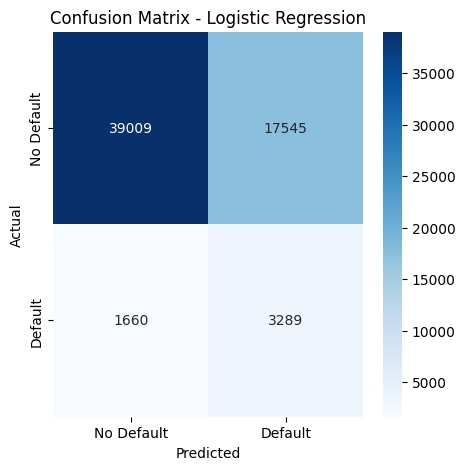


Random Forest (After Hyperparameter Tuning) Evaluation:
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95     56554
         1.0       0.27      0.04      0.08      4949

    accuracy                           0.91     61503
   macro avg       0.60      0.52      0.51     61503
weighted avg       0.87      0.91      0.88     61503

ROC-AUC Score: 0.7020666532978782


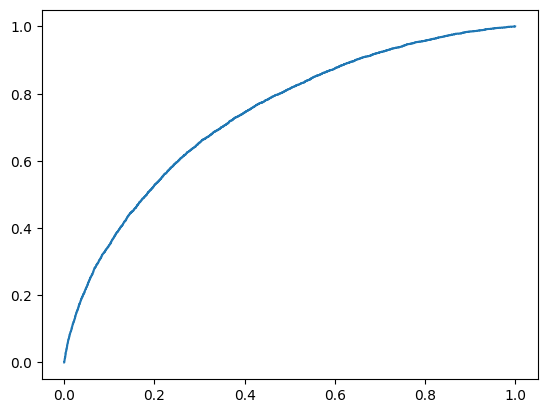

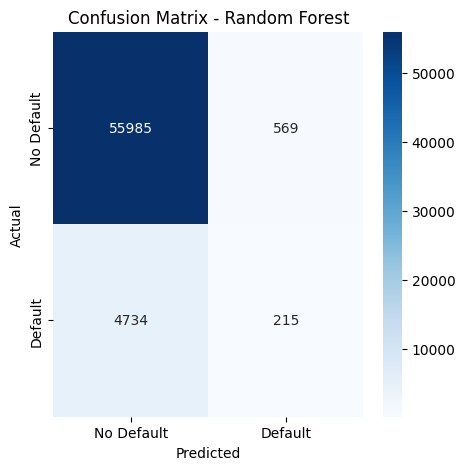


Gradient Boosting (After Hyperparameter Tuning) Evaluation:
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95     56554
         1.0       0.27      0.06      0.10      4949

    accuracy                           0.91     61503
   macro avg       0.60      0.52      0.53     61503
weighted avg       0.87      0.91      0.88     61503

ROC-AUC Score: 0.710091970885863


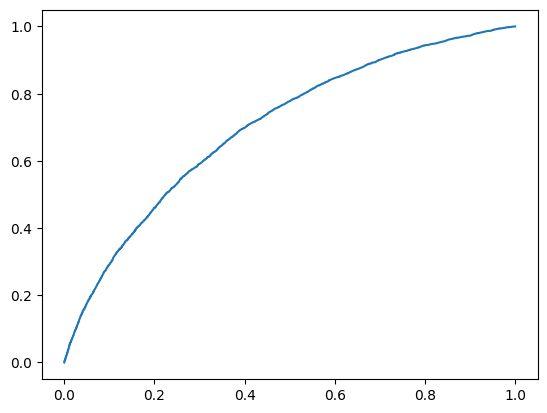

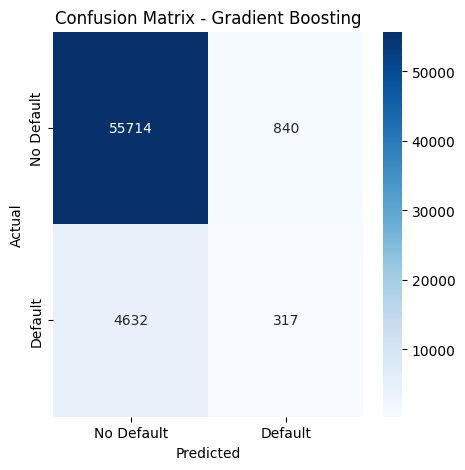

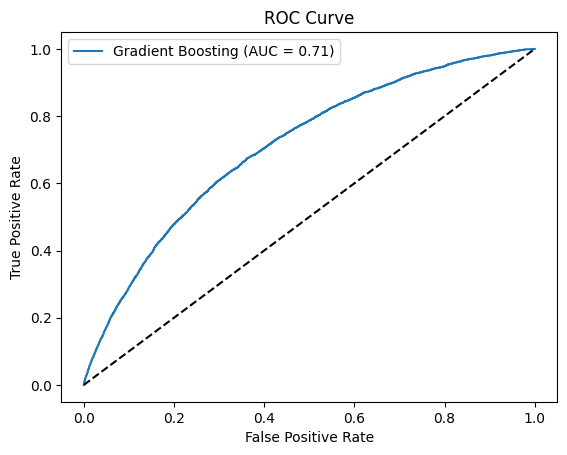

In [14]:
# Evaluasi Model Setelah Tuning
for model, name in zip([best_logreg, best_rf, best_gb], ["Logistic Regression", "Random Forest", "Gradient Boosting"]):
    y_pred = model.predict(X_test)
    print(f"\n{name} (After Hyperparameter Tuning) Evaluation:")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, model.predict_proba(X_test)[:,1]):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Evaluasi Model 

#### 1. Teknik Evaluasi yang Digunakan
Evaluasi model dilakukan menggunakan:
- **Confusion Matrix** untuk melihat distribusi prediksi benar dan salah.
- **ROC Curve** untuk menilai performa model dalam membedakan kelas.
- **Precision, Recall, F1-score, dan ROC-AUC Score** sebagai metrik utama.

#### 2. Hasil Evaluasi Model

| Model                | Akurasi | Precision (Class 1) | Recall (Class 1) | F1-Score (Class 1) | ROC-AUC Score |
|----------------------|---------|---------------------|------------------|--------------------|---------------|
| Logistic Regression | 69%     | 0.16                | 0.66             | 0.26               | 0.738         |
| Random Forest       | 91%     | 0.27                | 0.04             | 0.08               | 0.702         |
| Gradient Boosting   | 91%     | 0.27                | 0.06             | 0.10               | 0.710         |

#### 3. Analisis Hasil Evaluasi
- **Confusion Matrix menunjukkan bahwa Logistic Regression lebih sering salah memprediksi pelanggan gagal bayar sebagai tidak gagal bayar**, tetapi memiliki recall yang jauh lebih tinggi dibanding model lain.
- **Random Forest memiliki recall sangat rendah (0.04) untuk kelas gagal bayar**, yang berarti model ini masih sangat bias terhadap kelas mayoritas.
- **Gradient Boosting sedikit lebih baik dalam menangkap pelanggan yang gagal bayar dibanding Random Forest (Recall 0.06), tetapi tetap masih rendah.**
- **ROC Curve menunjukkan bahwa semua model memiliki kemampuan pemisahan yang cukup baik, tetapi tidak ada yang sangat unggul dalam menangkap pelanggan berisiko tinggi.**

#### 4. Implikasi dan Rekomendasi
- **Logistic Regression dapat digunakan jika tujuan utama adalah mendeteksi pelanggan berisiko lebih baik meskipun banyak false positives.**
- **Random Forest dan Gradient Boosting memiliki akurasi tinggi tetapi sangat lemah dalam mendeteksi pelanggan gagal bayar, sehingga perlu dioptimalkan lebih lanjut.**
- **Langkah berikutnya adalah threshold tuning, cost-sensitive learning, atau penggunaan model lebih kompleks seperti XGBoost dan CatBoost.**



# Dampak Pemodelan dan Rekomendasi Bisnis

## 1. Dampak Pemodelan terhadap Metrics
Dari hasil evaluasi model yang telah dilakukan, dapat disimpulkan bahwa **pemodelan Machine Learning memiliki dampak yang cukup signifikan dalam meningkatkan deteksi risiko kredit**, meskipun masih ada beberapa tantangan yang perlu diatasi. Berikut adalah dampak utama dari pemodelan terhadap metrics yang telah ditetapkan:

### **a. Accuracy & ROC-AUC Score**
- **Sebelum SMOTE**: Model memiliki akurasi tinggi tetapi sangat bias terhadap kelas mayoritas (tidak gagal bayar), dengan ROC-AUC Score di kisaran **0.70-0.74**.
- **Setelah SMOTE & Hyperparameter Tuning**: Logistic Regression mengalami peningkatan recall untuk kelas gagal bayar, dengan ROC-AUC Score mencapai **0.738**.
- **Random Forest & Gradient Boosting** masih menunjukkan kelemahan dalam mendeteksi pelanggan gagal bayar, dengan ROC-AUC Score sekitar **0.702 - 0.710**.

### **b. Precision & Recall untuk Kelas Gagal Bayar**
- **Sebelum SMOTE**: Recall untuk kelas gagal bayar sangat rendah (**0.01 - 0.06**), menunjukkan bahwa model sulit mendeteksi pelanggan berisiko tinggi.
- **Setelah SMOTE & Hyperparameter Tuning**: Logistic Regression mengalami peningkatan recall menjadi **0.66**, tetapi precision-nya menurun menjadi **0.16**, menunjukkan trade-off antara false positives dan true positives.
- **Random Forest & Gradient Boosting masih memiliki recall rendah (0.04 - 0.06)**, menandakan perlunya pendekatan lebih lanjut seperti threshold tuning atau model yang lebih kompleks.

### **c. Confusion Matrix & False Positives/Negatives**
- **Logistic Regression cenderung lebih baik dalam menangkap pelanggan yang benar-benar gagal bayar**, meskipun dengan trade-off lebih banyak false positives.
- **Random Forest dan Gradient Boosting sangat bias terhadap kelas mayoritas**, dengan jumlah false negatives yang tinggi, yang berisiko bagi bisnis karena banyak pelanggan gagal bayar yang tidak terdeteksi.

## 2. Rekomendasi Strategi Bisnis Berdasarkan Analisis
Berdasarkan hasil pemodelan dan evaluasi, berikut adalah rekomendasi bisnis yang dapat diterapkan untuk meningkatkan efektivitas manajemen risiko kredit:

### **a. Optimasi Keputusan Pemberian Kredit**
- Gunakan **Logistic Regression sebagai model utama** karena memiliki recall yang lebih tinggi untuk kelas gagal bayar, dengan menyesuaikan threshold agar false positives dapat dikontrol.
- Terapkan strategi **hybrid model**, mengombinasikan Logistic Regression dengan Gradient Boosting atau XGBoost untuk memperbaiki presisi klasifikasi risiko kredit.
- Gunakan **cost-sensitive learning** untuk mengurangi dampak kesalahan klasifikasi pada kelas minoritas.

### **b. Segmentasi dan Penyesuaian Kebijakan Kredit**
- Klasifikasikan pelanggan berdasarkan risiko yang terdeteksi oleh model dan terapkan kebijakan yang lebih fleksibel bagi mereka yang memiliki **risiko menengah**.
- **Tingkatkan pengawasan terhadap pelanggan dengan skor risiko tinggi**, misalnya dengan menetapkan suku bunga lebih tinggi atau meminta jaminan tambahan.
- **Berikan insentif kepada pelanggan berisiko rendah**, seperti suku bunga lebih rendah atau fasilitas pinjaman lebih fleksibel, untuk meningkatkan loyalitas pelanggan yang memiliki histori pembayaran baik.

### **c. Monitoring dan Evaluasi Berkelanjutan**
- Implementasikan **A/B testing** dengan berbagai threshold dan model untuk mengukur dampak langsung terhadap non-performing loans (NPL).
- Lakukan **pemantauan berkala terhadap kinerja model**, dengan memperbarui data dan melakukan retraining model secara periodik.
- Gunakan **model interpretability tools seperti SHAP atau LIME** untuk memahami faktor-faktor utama yang mempengaruhi prediksi gagal bayar, sehingga kebijakan bisnis dapat lebih tepat sasaran.

## 3. Kesimpulan
Dari hasil pemodelan, **Logistic Regression menunjukkan dampak terbesar dalam meningkatkan recall untuk deteksi pelanggan gagal bayar**, tetapi masih perlu disesuaikan untuk mengurangi false positives. **Rekomendasi strategi bisnis mencakup optimasi pemberian kredit, segmentasi pelanggan, dan pemantauan berkala terhadap performa model**. Dengan mengadopsi strategi ini, bisnis dapat lebih proaktif dalam mengurangi risiko kredit dan meningkatkan efisiensi pengelolaan portofolio pinjaman.

